# Noise2Noise PyTorch 实现
 
本笔记本包含了使用PyTorch实现的Noise2Noise论文的简短演示,使用32x32大小的图像

In [2]:
import torch
import numpy as np

from matplotlib import pyplot as plt
from time import time

from model import Model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'The model will be loaded on the {"GPU" if device == "cuda" else "cpu"}.')

# 加载训练数据和验证数据
# 使用了ImageNet的32x32图像，其中包含随机高斯噪声。这些图像以PyTorch的pickle文件的形式提供
noisy_imgs_1, noisy_imgs_2 = torch.load('train_data.pkl')
noisy_imgs, clean_imgs = torch.load('val_data.pkl')

The model will be loaded on the GPU.


C:\Users\Galax\AppData\Local\Temp\ipykernel_2960\720789997.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  noisy_imgs_1, noisy_imgs_2 = torch.load('train_data.pkl')
C:\

# 可视化方法

In [3]:
def display_rgb(img):
    """
    显示RGB图像
    :param img: 输入图像张量，形状为(C,H,W)
    """
    plt.imshow(img.permute(1,2,0))
    plt.show()

def psnr_eval(model, noisy_imgs, ground_truth, nb_images=3, must_randomize=True):
    """
    评估模型性能并可视化结果
    :param model: 待评估的模型
    :param noisy_imgs: 噪声图像
    :param ground_truth: 干净图像(真值)
    :param nb_images: 显示的图像数量
    :param must_randomize: 是否随机选择显示的图像
    """
    def psnr(denoised, ground_truth):
        """
        计算峰值信噪比(PSNR)
        :param denoised: 去噪后的图像
        :param ground_truth: 干净图像(真值)
        :return: PSNR值(dB)
        """
        mse = torch.mean((denoised.cpu() - ground_truth.cpu()) ** 2)
        return -10 * torch.log10(mse + 10 ** -8)

    # 转换数据类型
    noised = noisy_imgs.float()
    ground_truth = ground_truth.float()

    # 使用模型进行预测
    denoised = model.predict(noised) / 255

    # 计算并打印PSNR
    psnr_result = psnr(denoised, (ground_truth / 255)).item()
    print(f'PSNR result: {psnr_result:.2f} dB')

    # 创建子图
    f, axarr = plt.subplots(nb_images, 3)

    # 选择要显示的图像索引
    if must_randomize:
        nb_index = np.random.choice(len(noised), nb_images)
    else:
        nb_index = np.arange(nb_images)
    
    # 设置列标题
    axarr[0, 0].set_title("Noisy Images")
    axarr[0, 1].set_title("Denoised")
    axarr[0, 2].set_title("Ground Truth")

    # 显示图像
    for i, index in enumerate(nb_index):
        # 显示噪声图像
        axarr[i, 0].imshow(noisy_imgs[index].permute(1,2,0))
        axarr[i,0].get_yaxis().set_visible(False)
        axarr[i,0].get_xaxis().set_visible(False)
        # 显示去噪后的图像
        axarr[i, 1].imshow(denoised[index].cpu().detach().permute(1,2,0))
        axarr[i, 1].get_yaxis().set_visible(False)
        axarr[i, 1].get_xaxis().set_visible(False)
        # 显示干净图像
        axarr[i, 2].imshow(clean_imgs[index].permute(1,2,0))
        axarr[i, 2].get_yaxis().set_visible(False)
        axarr[i, 2].get_xaxis().set_visible(False)
    plt.show()

## 模型训练

In [4]:
model = Model()
model.train(noisy_imgs_1, noisy_imgs_2, num_epochs=5, batch_size=8, num_workers=3)

Epoch [4/5]: 100%|██████████| 6250/6250 [00:57<00:00, 108.47it/s, loss=0.0162]


PSNR result: 23.04 dB


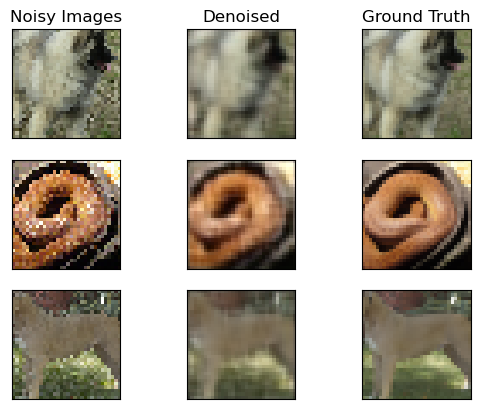

In [8]:
psnr_eval(model, noisy_imgs, clean_imgs)